# XGboost - Extreme Gradient Boosting

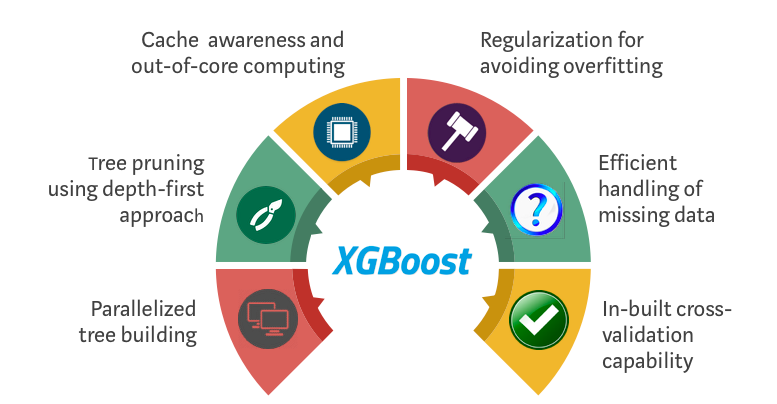

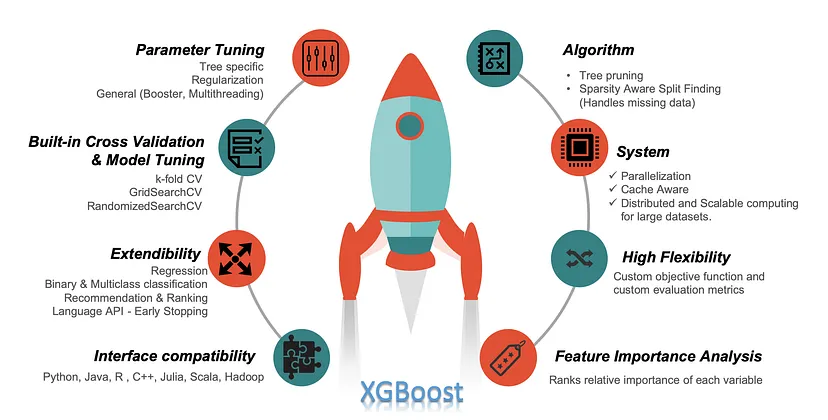

In [2]:
from warnings import filterwarnings
filterwarnings("ignore")

In [3]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Step 1 - Load train data

In [4]:
import pandas as pd
df = pd.read_csv("train_loan.csv")
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


### Target Loan status
1. 0 - rejected
2. 1 - approved

### Step 2 - Perform basic data quality checks

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [6]:
df.isna().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

### Step 3 -Seperate X and Y

In [8]:
X = df.drop(columns=["id", "loan_status"])
Y = df[["loan_status"]]

In [9]:
X.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3


In [10]:
Y.head()

,loan_status
0,0
1,0
2,0
3,0
4,0


In [11]:
Y.value_counts()

loan_status
0              50295
1               8350
Name: count, dtype: int64

### Step 4 - Apply Preprocessing on X

In [12]:
cat = list(X.columns[X.dtypes == "object"])
con = list(X.columns[X.dtypes != "object"])

In [13]:
cat

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [14]:
con

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length']

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [16]:
num_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

In [17]:
cat_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

In [18]:
pre = ColumnTransformer(
    [
        ("num", num_pipe, con),
        ("cat", cat_pipe, cat)
    ]
).set_output(transform="pandas")

In [19]:
X_pre = pre.fit_transform(X)
X_pre.head()

,num__person_age,num__person_income,num__person_emp_length,num__loan_amnt,num__loan_int_rate,num__loan_percent_income,num__cb_person_cred_hist_length,cat__person_home_ownership_MORTGAGE,cat__person_home_ownership_OTHER,cat__person_home_ownership_OWN,...,cat__loan_intent_VENTURE,cat__loan_grade_A,cat__loan_grade_B,cat__loan_grade_C,cat__loan_grade_D,cat__loan_grade_E,cat__loan_grade_F,cat__loan_grade_G,cat__cb_person_default_on_file_N,cat__cb_person_default_on_file_Y
0,1.566200,-0.765768,-1.187200,-0.578306,0.267616,0.117378,2.031798,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.920057,-0.212128,0.328047,-0.937775,0.880532,-0.973242,-0.946489,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.240196,-0.929223,0.833130,-0.578306,-0.585854,0.553626,1.039036,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.405947,0.156966,2.348377,0.500101,0.142396,0.117378,-0.201917,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.920057,-0.106673,-0.682117,-0.578306,-1.238314,-0.646056,-0.698298,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Step 5 - Train test split

In [20]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y, test_size=0.2, random_state=42)

In [21]:
xtrain.head()

,num__person_age,num__person_income,num__person_emp_length,num__loan_amnt,num__loan_int_rate,num__loan_percent_income,num__cb_person_cred_hist_length,cat__person_home_ownership_MORTGAGE,cat__person_home_ownership_OTHER,cat__person_home_ownership_OWN,...,cat__loan_intent_VENTURE,cat__loan_grade_A,cat__loan_grade_B,cat__loan_grade_C,cat__loan_grade_D,cat__loan_grade_E,cat__loan_grade_F,cat__loan_grade_G,cat__cb_person_default_on_file_N,cat__cb_person_default_on_file_Y
14337,1.400450,-0.370311,-1.187200,-0.362625,1.045295,-0.209808,2.279989,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
17117,-0.091305,-0.549585,-0.429576,-0.758041,0.323635,-0.427932,0.790845,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
32590,-0.422806,0.156966,-1.187200,-0.218837,-0.921970,-0.536994,-0.698298,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
55811,1.897701,0.288785,-0.682117,1.039305,-1.363533,0.444564,1.287227,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
40120,-0.920057,-0.486311,0.075506,-0.937775,-0.994465,-0.755118,-0.946489,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
ytrain.head()

,loan_status
14337,0
17117,0
32590,0
55811,0
40120,0


In [23]:
xtest.head()

,num__person_age,num__person_income,num__person_emp_length,num__loan_amnt,num__loan_int_rate,num__loan_percent_income,num__cb_person_cred_hist_length,cat__person_home_ownership_MORTGAGE,cat__person_home_ownership_OTHER,cat__person_home_ownership_OWN,...,cat__loan_intent_VENTURE,cat__loan_grade_A,cat__loan_grade_B,cat__loan_grade_C,cat__loan_grade_D,cat__loan_grade_E,cat__loan_grade_F,cat__loan_grade_G,cat__cb_person_default_on_file_N,cat__cb_person_default_on_file_Y
4657,-0.754307,-0.633949,-1.187200,-0.991696,-0.882427,-0.755118,-0.450108,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
56440,-0.422806,-0.106673,1.085671,-0.758041,-0.688007,-0.864180,-0.450108,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
42117,0.737448,0.059419,-1.187200,1.937978,0.610322,1.098935,0.046274,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10849,-0.920057,-0.897587,-1.187200,-0.758041,-0.028957,0.117378,-0.946489,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39395,-0.091305,-0.106673,-0.934659,-0.398572,0.504874,-0.427932,1.039036,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
ytest.head()

,loan_status
4657,0
56440,0
42117,1
10849,0
39395,0


In [25]:
xtrain.shape

(46916, 26)

In [26]:
xtest.shape

(11729, 26)

### Step 6 - Model Building

In [27]:
import xgboost as xgb

In [28]:
model = xgb.XGBClassifier(
    max_depth = 3,
    n_estimators = 300,
    random_state = 60
)
model.fit(xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=60, ...)

### Step 7 - Model Evaluation

In [29]:
model.score(xtrain, ytrain)

0.9573493051411033

In [30]:
model.score(xtest, ytest)

0.9524256117316054

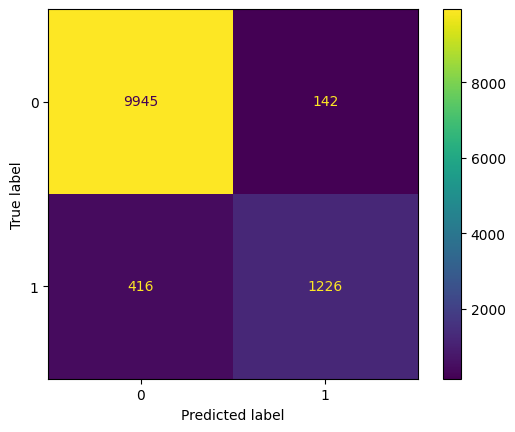

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, xtest, ytest)

In [32]:
ypred_test = model.predict(xtest)
ypred_test[0:5]

array([0, 0, 0, 0, 0])

In [33]:
ytest.head()

,loan_status
4657,0
56440,0
42117,1
10849,0
39395,0


In [34]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred_test))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10087
           1       0.90      0.75      0.81      1642

    accuracy                           0.95     11729
   macro avg       0.93      0.87      0.89     11729
weighted avg       0.95      0.95      0.95     11729



In [35]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, xtrain, ytrain, cv=5, scoring="f1_macro")
scores

array([0.88764614, 0.88423126, 0.90220069, 0.89537845, 0.88625425])

In [36]:
scores.mean()

np.float64(0.8911421599153282)

### Using above i can clearly get f1_macro of 0.89 in test and cross validation hence above model is a good model

In [37]:
model.feature_importances_

array([0.00387064, 0.01947783, 0.01862443, 0.00428349, 0.04403992,
       0.10374644, 0.00392153, 0.0063185 , 0.00466923, 0.04363473,
       0.19739027, 0.05647333, 0.01411412, 0.04163333, 0.03797329,
       0.00718044, 0.02956604, 0.00921509, 0.00627501, 0.02897024,
       0.29350016, 0.01524531, 0.0027342 , 0.00271338, 0.00442899,
       0.        ], dtype=float32)

In [38]:
xtrain.columns

Index(['num__person_age', 'num__person_income', 'num__person_emp_length',
       'num__loan_amnt', 'num__loan_int_rate', 'num__loan_percent_income',
       'num__cb_person_cred_hist_length',
       'cat__person_home_ownership_MORTGAGE',
       'cat__person_home_ownership_OTHER', 'cat__person_home_ownership_OWN',
       'cat__person_home_ownership_RENT', 'cat__loan_intent_DEBTCONSOLIDATION',
       'cat__loan_intent_EDUCATION', 'cat__loan_intent_HOMEIMPROVEMENT',
       'cat__loan_intent_MEDICAL', 'cat__loan_intent_PERSONAL',
       'cat__loan_intent_VENTURE', 'cat__loan_grade_A', 'cat__loan_grade_B',
       'cat__loan_grade_C', 'cat__loan_grade_D', 'cat__loan_grade_E',
       'cat__loan_grade_F', 'cat__loan_grade_G',
       'cat__cb_person_default_on_file_N', 'cat__cb_person_default_on_file_Y'],
      dtype='object')

In [39]:
imp = pd.Series(model.feature_importances_, index=xtrain.columns)
imp

num__person_age                        0.003871
num__person_income                     0.019478
num__person_emp_length                 0.018624
num__loan_amnt                         0.004283
num__loan_int_rate                     0.044040
num__loan_percent_income               0.103746
num__cb_person_cred_hist_length        0.003922
cat__person_home_ownership_MORTGAGE    0.006319
cat__person_home_ownership_OTHER       0.004669
cat__person_home_ownership_OWN         0.043635
cat__person_home_ownership_RENT        0.197390
cat__loan_intent_DEBTCONSOLIDATION     0.056473
cat__loan_intent_EDUCATION             0.014114
cat__loan_intent_HOMEIMPROVEMENT       0.041633
cat__loan_intent_MEDICAL               0.037973
cat__loan_intent_PERSONAL              0.007180
cat__loan_intent_VENTURE               0.029566
cat__loan_grade_A                      0.009215
cat__loan_grade_B                      0.006275
cat__loan_grade_C                      0.028970
cat__loan_grade_D                      0

In [40]:
s = imp.sort_values(ascending=False)
s

cat__loan_grade_D                      0.293500
cat__person_home_ownership_RENT        0.197390
num__loan_percent_income               0.103746
cat__loan_intent_DEBTCONSOLIDATION     0.056473
num__loan_int_rate                     0.044040
cat__person_home_ownership_OWN         0.043635
cat__loan_intent_HOMEIMPROVEMENT       0.041633
cat__loan_intent_MEDICAL               0.037973
cat__loan_intent_VENTURE               0.029566
cat__loan_grade_C                      0.028970
num__person_income                     0.019478
num__person_emp_length                 0.018624
cat__loan_grade_E                      0.015245
cat__loan_intent_EDUCATION             0.014114
cat__loan_grade_A                      0.009215
cat__loan_intent_PERSONAL              0.007180
cat__person_home_ownership_MORTGAGE    0.006319
cat__loan_grade_B                      0.006275
cat__person_home_ownership_OTHER       0.004669
cat__cb_person_default_on_file_N       0.004429
num__loan_amnt                         0

<Axes: >

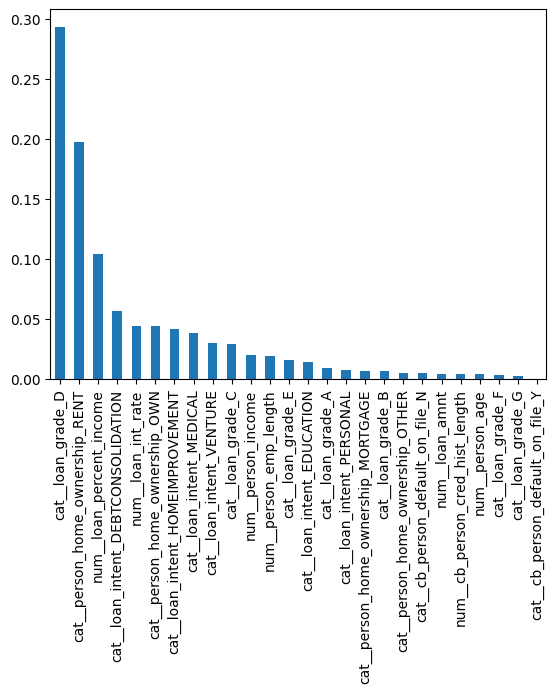

In [41]:
s.plot(kind="bar")

<Axes: >

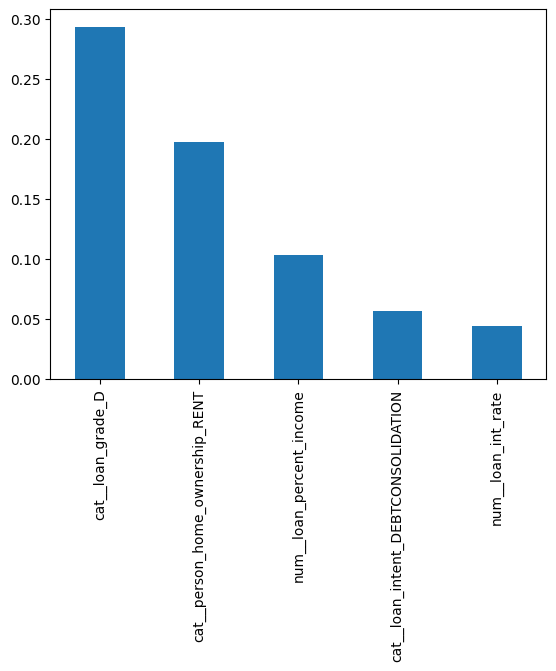

In [42]:
s.head(5).plot(kind="bar")

### Step 8 - Out of sample prediction

In [44]:
xnew = pd.read_csv("test_loan.csv")
xnew

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
39093,97738,22,31200,MORTGAGE,2.0,DEBTCONSOLIDATION,B,3000,10.37,0.10,N,4
39094,97739,22,48000,MORTGAGE,6.0,EDUCATION,A,7000,6.03,0.15,N,3
39095,97740,51,60000,MORTGAGE,0.0,PERSONAL,A,15000,7.51,0.25,N,25
39096,97741,22,36000,MORTGAGE,4.0,PERSONAL,D,14000,15.62,0.39,Y,4


In [45]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['person_age', 'person_income',
                                  'person_emp_length', 'loan_amnt',
                                  'loan_int_rate', 'loan_percent_income',
                                  'cb_person_cred_hist_length']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['person_home_ownership', 'loan_intent',
                                  'loan_grade', 'cb_person_default_on_file'])])

In [46]:
xnew_pre = pre.transform(xnew)
xnew_pre.head()

,num__person_age,num__person_income,num__person_emp_length,num__loan_amnt,num__loan_int_rate,num__loan_percent_income,num__cb_person_cred_hist_length,cat__person_home_ownership_MORTGAGE,cat__person_home_ownership_OTHER,cat__person_home_ownership_OWN,...,cat__loan_intent_VENTURE,cat__loan_grade_A,cat__loan_grade_B,cat__loan_grade_C,cat__loan_grade_D,cat__loan_grade_E,cat__loan_grade_F,cat__loan_grade_G,cat__cb_person_default_on_file_N,cat__cb_person_default_on_file_Y
0,-0.754307,0.130602,-0.429576,2.836651,1.674687,2.189555,-0.946489,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.257055,0.842425,0.328047,0.140632,0.659750,-0.646056,-0.450108,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.257055,-0.897587,0.075506,-0.937775,2.145908,-0.318870,-0.946489,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.903198,-0.370311,-0.177035,-0.398572,-0.585854,-0.209808,0.294464,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.257055,1.000608,0.833130,1.039305,1.859221,-0.100746,-0.450108,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [48]:
preds = model.predict(xnew_pre)
preds[0:5]

array([1, 0, 1, 0, 0])

In [50]:
model.classes_

array([0, 1])

In [52]:
probs = model.predict_proba(xnew_pre)[:, 1]
probs[0:5]

array([0.99844223, 0.02228034, 0.5306855 , 0.00702703, 0.02342577],
      dtype=float32)

### Save above results in dataframe

In [53]:
results = xnew[["id"]]
results["loan_pred"] = preds
results["loan_prob"] = probs

In [55]:
results = results.round(4)
results

,id,loan_pred,loan_prob
0,58645,1,0.9984
1,58646,0,0.0223
2,58647,1,0.5307
3,58648,0,0.0070
4,58649,0,0.0234
...,...,...,...
39093,97738,0,0.0416
39094,97739,0,0.0030
39095,97740,0,0.0066
39096,97741,0,0.1283


In [56]:
results["loan_pred"].value_counts()

loan_pred
0    34725
1     4373
Name: count, dtype: int64

<Axes: xlabel='loan_pred'>

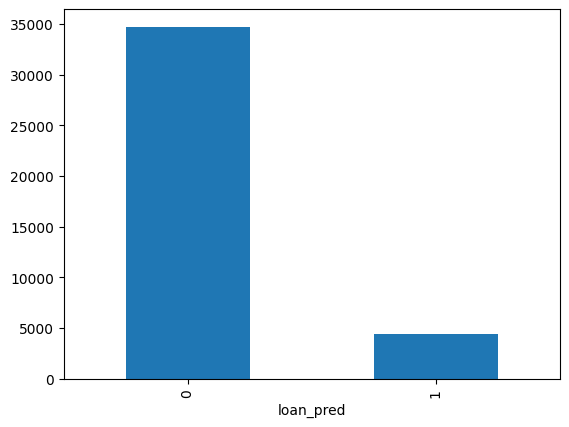

In [57]:
results["loan_pred"].value_counts().plot(kind="bar")

In [58]:
results.to_csv("LoanResults.csv", index= False)